# Surface water mass transformation (WMT) analysis

In [1]:
import xarray as xr

## Loading a dataset
Update `rootdir` with your own dataset's path. All relevant variables will be loaded into `ds` and the (static) grid data will be loaded into a separate dataset.

In [2]:
rootdir = '/scratch/cimes/jt7058/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/'
ds = xr.open_mfdataset([rootdir+'19030101.ocean_month.nc',rootdir+'19030101.ocean_month_z.nc'])
grid = xr.open_dataset(rootdir+'19030101.ocean_static.nc').squeeze().reset_coords(drop=True)

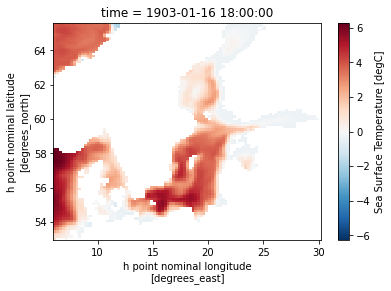

In [3]:
ds.tos[0].plot()

The dataset includes all availabe surface flux fields. For this tutorial we are focusing on the most essential ones which represents the surface tracer fields (SST and SSS) and the total net heat, freshwater and salt fluxes.
- `tos`: Sea Surface Temperature (units: degC)
> Temperature of upper boundary of the liquid ocean, including temperatures below sea-ice and floating ice shelves.
- `sos`: Sea Surface Salinity (units: 0.001) 
> Sea water salinity is the salt content of sea water, often on the Practical Salinity Scale of 1978. However, the unqualified term 'salinity' is generic and does not necessarily imply any particular method of calculation. The units of salinity are dimensionless and the units attribute should normally be given as 1e-3 or 0.001 i.e. parts per thousand. 
- `hfds`: Downward Heat Flux at Sea Water Surface (units: W m-2)
> This is the net flux of heat entering the liquid water column through its upper surface (excluding any "flux adjustment").
- `wfo`: Water Flux into Sea Water (units: kg m-2 s-1)
> Computed as the water flux into the ocean divided by the area of the ocean portion of the grid cell. This is the sum *wfonocorr* and *wfcorr*.
- `sfdsi`: Downward Sea Ice Basal Salt Flux (units: kg m-2 s-1)
> This field is physical, and it arises since sea ice has a nonzero salt content, so it exchanges salt with the liquid ocean upon melting and freezing.

### Preprocessing
The wmt package includes a separate routine ensures consistency among different models. In the case for MOM6 data (such as CM4), it combines the variable and grid info and sets the dimension and coordinate names to a common standard.

In [4]:
from xwmt.preprocessing import preprocessing

In [5]:
help(preprocessing)

Help on function preprocessing in module xwmt.preprocessing:

preprocessing(ds, grid, decode_times=True, shift_coords=False, reset_time_axis=False, rechunk=True, verbose=True)
    Preprocessing routine for watermass transformation (WMT).
    
    Parameters
    ----------
    ds : xarray.Dataset
        Includes all the relevant variables for surface and/or 3d WMT
    grid : xarray.Dataset
        Includes all the relevant grid variables (e.g., cell area) and coordinates
    decode_times : boolean, optional
        Option to decode time axis according to CF conventions and convert to np.datetime64[ns] object. True by default.
    shift_coords : boolean, optional
        Option to shift lon and lat to always be -180 to 180 and -90 to 90, respectively. Flase by default.
    reset_time_axis : boolean, optional
        Option to reset time axis. New time coordinate will be created with pandas.date_range 
        and given frequency (e.g., 'MS', 'YS'). False by default.
    rechunk : boolea

In [6]:
ds = preprocessing(ds, grid, verbose=True).drop_dims(['lev','lev_outer'])

Check grid dimensions: ['xh', 'yh']
Rename dimensions: {'xh': 'x', 'yh': 'y', 'z_i': 'lev_outer', 'z_l': 'lev'}
Rename data variables {'geolat': 'lat', 'geolon': 'lon'}
Temperature attributes:
 thetao {'long_name': 'Sea Water Potential Temperature', 'units': 'degC', 'cell_methods': 'area:mean z_l:mean yh:mean xh:mean time: mean', 'cell_measures': 'volume: volcello area: areacello', 'time_avg_info': 'average_T1,average_T2,average_DT', 'standard_name': 'sea_water_potential_temperature'}
Temperature attributes:
 tos {'long_name': 'Sea Surface Temperature', 'units': 'degC', 'cell_methods': 'area:mean yh:mean xh:mean time: mean', 'cell_measures': 'area: areacello', 'time_avg_info': 'average_T1,average_T2,average_DT', 'standard_name': 'sea_surface_temperature'}
Salt flux attributes:
 sfdsi {'long_name': 'Downward Sea Ice Basal Salt Flux', 'units': 'kg m-2 s-1', 'cell_methods': 'area:mean yh:mean xh:mean time: mean', 'cell_measures': 'area: areacello', 'time_avg_info': 'average_T1,average_T2,

**Note**: Since we are only interested in surface fields, `.drop_dims(['lev','lev_outer'])` removes all variables with depth dimensions (`lev` or `lev_outer`).

## Surface WMT using `swmt` class

The first step is to initialize the class by creating an object. This object includes all the calculations for surface WMT (`swmt`).

In [7]:
from xwmt.swmt import swmt

In [8]:
dd = swmt(ds)

The `swmt` class object includes multiple functions to look at the relevant data. The most common function is `.G()` which gives you the WMT along $\lambda$ (i.e., $G(\lambda)$). Here, we need to define $\lambda$. For example, 'theta' for potential temperature ($\theta$) or 'sigma0' for potential density referenced at 0 dbar ($\sigma_0$). You can use command `.lambdas()` for a list of available $\lambda$'s. Here, we will go with $\sigma_0$. This is all you need, but if you want to define the size of the bins you can do that with the argument `bin`.

In [9]:
from xwmt.compute import lbin_define

In [10]:
G = dd.G('sigma0', bins=lbin_define(18.0,28.5,0.1))

There is a separate function `lbin_define` available that outputs an array of bin edgest used for the WMT calculation. Since we are looking at the global ocean, we use the full range where most of surface density falls in the open ocean (18 to 28.5 kg m$^{-3}$) with a bin size of 0.1 kg m$^{-3}$.

The output (`G`) is a xarray Data.Array with dimensions `time` and `sigma0` (or whatever $\lambda$ you selected). When plotting `G` by itself, you will get WMT along $\sigma_0$ and time (i.e., a Hovmöller diagram). Plotting the whole data array might take a few minutes (because this step requires us to load the data into memory).

In [11]:
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed |  0.2s


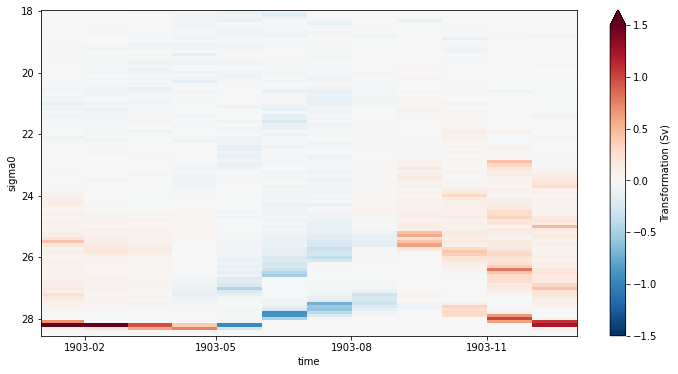

In [12]:
with ProgressBar():
    (G*1e-6).T.plot(figsize=(12,6),cmap='RdBu_r',vmin=-1.5,vmax=1.5,yincrease=False,
                    cbar_kwargs={'label': 'Transformation (Sv)'})

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Globally, we see densification at higher densities ($\sigma_0$ > 24 kg m$^{-3}$) mostly between May to August and lightenting of waters at lower densities ($\sigma_0$ < 24 kg m$^{-3}$), especially from February and March. Finally, let's look at the mean WMT along $\sigma_0$.

In [14]:
with ProgressBar():
    G_mean = G.mean('time').load()

[########################################] | 100% Completed |  0.2s


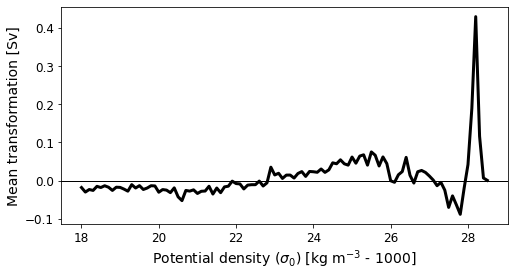

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G['sigma0'], G_mean*1e-6, c='k', lw=3, ls='-')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=14)
ax.set_ylabel('Mean transformation [Sv]',fontsize=14)
plt.show()

The global mean picture: Water masses are mostly transformed to denser classes when $\sigma_0$ > 24 kg m$^{-3}$ and to lighter classes when $\sigma_0$ < 24 kg m$^{-3}$. We can also decompose $G$ into heat (i.e., thermal) and freshwater/salt (i.e., haline) components. This can be done by setting keyword `group_tend=False` when running `.G()`.

In [17]:
formation = -1.*G_mean.diff("sigma0")

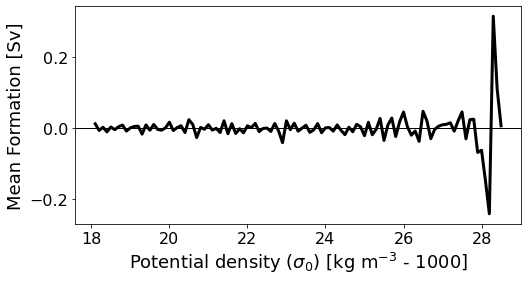

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(formation.sigma0, formation*1e-6, color='k', linestyle='-', lw=3, label='Total')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=18)
ax.set_ylabel('Mean Formation [Sv]',fontsize=18)
plt.show()

The water mass formation rate can be obtained by differentiating the transformation function along $\lambda$, or in this case, `sigma0`. We see surface water mass formation ocurring in the tropics ($\sigma$ < 22 kg/m3 ) at rates generally less than 10 Sv. The other maxima of surface water mass formation occuring at higher densities ($\sigma$ > 26.5) are associated with mode water formation. 

In [19]:
G = dd.G('sigma0', bins=lbin_define(18.0,28.5,0.1), group_tend=False)

In [20]:
with ProgressBar():
    G_mean = G.mean('time').load()

[########################################] | 100% Completed |  0.2s


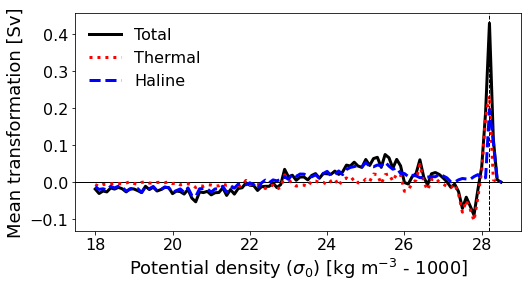

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(G['sigma0'], (G_mean.heat+G_mean.salt)*1e-6, color='k', linestyle='-', lw=3, label='Total')
ax.plot(G['sigma0'], G_mean.heat*1e-6, color='r', linestyle=':', lw=3, label='Thermal')
ax.plot(G['sigma0'], G_mean.salt*1e-6, color='b', linestyle='--', lw=3, label='Haline')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Potential density ($\sigma_0$) [kg m$^{-3}$ - 1000]',fontsize=18)
ax.set_ylabel('Mean transformation [Sv]',fontsize=18)
ax.legend(frameon=False, fancybox=False, loc='upper left', ncol=1, fontsize=16)
ax.axvline(x=28.2, c = 'k', ls='--', lw=1, label=r' $\sigma_1$ = 32.51 kg m$^{-3}$')

plt.show()

Here we can see that the haline part is actually counteracting the thermal part in most instances. The thermal part dominates surface WMT in most densities (at a global scale).

We can map the spatial distribution of transformation for a given isopycnal. Here we choose 28.2, which corresponds to the peak in the above graph.

In [22]:
with ProgressBar():
    F_mean = dd.isosurface_mean('sigma0', 28.2, dl = 0.1).load()

[#############################           ] | 73% Completed |  0.1s

/home/jt7058/.conda/envs/myenv/lib/python3.8/site-packages/xgcm/grid.py:965: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/jt7058/.conda/envs/myenv/lib/python3.8/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/jt7058/.conda/envs/myenv/lib/python3.8/site-packages/xgcm/grid.py:965: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/home/jt7058/.conda/envs/myenv/lib/python3.8/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in 

[########################################] | 100% Completed |  0.2s


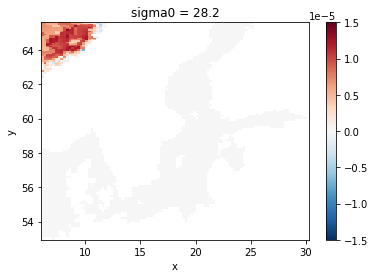

In [23]:
F_mean.where(ds.wet==1).plot(vmin=-1.5e-5,vmax=1.5e-5,cmap='RdBu_r')

Maximum WMT occurs *not* in the the Baltic Sea, but off the coast of Norway.